In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(1)

In [3]:
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = False   # set to True if haven't download the data

In [4]:
mnist_base_path="/Users/zhouwencheng/Desktop/Grass/data/picture/mnist"
train_data = dsets.MNIST(
    root = mnist_base_path,
    train=True,
    transform=transforms.ToTensor(), # (0, 1)
    download=DOWNLOAD_MNIST
)

torch.Size([60000, 28, 28])
torch.Size([60000])


/Users/zhouwencheng/Desktop/Grass/02Study/02PythonEnv/1env2/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Text(0.5, 1.0, 'tensor(5)')

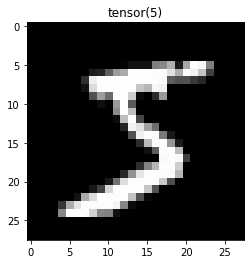

In [5]:
# plot one exmple
print(train_data.train_data.size())
print(train_data.targets.size())
plt.imshow(train_data.train_data[0].numpy(), cmap='gray') 
plt.title('%s'%train_data.targets[0])

In [6]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# convert test data into Variable, pick 2000 samples to speed up testing
mnist_base_path="/Users/zhouwencheng/Desktop/Grass/data/picture/mnist"

test_data = dsets.MNIST(root=mnist_base_path, train=False, transform=transforms.ToTensor())
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.
test_y = test_data.targets.numpy().squeeze()[:2000]

/Users/zhouwencheng/Desktop/Grass/02Study/02PythonEnv/1env2/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/zhouwencheng/Desktop/Grass/02Study/02PythonEnv/1env2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(               # if use nn.RNN(), it hardly learns
            input_size = INPUT_SIZE,
            hidden_size = 64,     # rnn hidden unit
            num_layers = 1,        # number of rnn layer
            batch_first = True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(64, 10)
        
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None) # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1,:])
        return out

In [14]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [15]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss() # the target label is not one-hotted

In [18]:
# train and testing

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28, 28))
        b_y = Variable(y)
        
        output = rnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 50 == 0:
            test_output = rnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y)/float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            print(loss.data)
            
            

Epoch:  0 | train loss: 0.2258 | test accuracy: 0.94
tensor(0.2258)
Epoch:  0 | train loss: 0.1654 | test accuracy: 0.95
tensor(0.1654)
Epoch:  0 | train loss: 0.0942 | test accuracy: 0.96
tensor(0.0942)
Epoch:  0 | train loss: 0.2505 | test accuracy: 0.95
tensor(0.2505)
Epoch:  0 | train loss: 0.1301 | test accuracy: 0.95
tensor(0.1301)
Epoch:  0 | train loss: 0.0812 | test accuracy: 0.96
tensor(0.0812)
Epoch:  0 | train loss: 0.1314 | test accuracy: 0.95
tensor(0.1314)
Epoch:  0 | train loss: 0.0213 | test accuracy: 0.96
tensor(0.0213)
Epoch:  0 | train loss: 0.0142 | test accuracy: 0.96
tensor(0.0142)
Epoch:  0 | train loss: 0.0332 | test accuracy: 0.94
tensor(0.0332)
Epoch:  0 | train loss: 0.0630 | test accuracy: 0.96
tensor(0.0630)
Epoch:  0 | train loss: 0.1917 | test accuracy: 0.96
tensor(0.1917)
Epoch:  0 | train loss: 0.1072 | test accuracy: 0.95
tensor(0.1072)
Epoch:  0 | train loss: 0.2281 | test accuracy: 0.97
tensor(0.2281)
Epoch:  0 | train loss: 0.1558 | test accuracy: 

In [27]:
# print 10 predictions from test data
test_out = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_out, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [41]:
torch.max(test_out, 1).indices.data.numpy().squeeze()

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])